# Pré-processamento

In [1]:
!pip install matplotlib nltk pandas seaborn wordcloud

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk

In [3]:
products_data = pd.read_csv('produtos.csv', delimiter=';')
products_data.head()

,nome,descricao,categoria
0,O Hobbit - 7ª Ed. 2013,Produto NovoBilbo Bolseiro é um hobbit que lev...,livro
1,Livro - It A Coisa - Stephen King,Produto NovoDurante as férias escolares de 195...,livro
2,Box As Crônicas De Gelo E Fogo Pocket 5 Li...,Produto NovoTodo o reino de Westeros ao alcanc...,livro
3,Box Harry Potter,Produto Novo e Físico A série Harry Potter ch...,livro
4,Livro Origem - Dan Brown,Produto NovoDe Onde Viemos? Para Onde Vamos? R...,livro


Alguns dados da coluna 'descrição' estão faltando, e todas as outras colunas não possuem valores nulos. Todos os dados são strings.

In [4]:
products_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   nome       4080 non-null   object
 1   descricao  2916 non-null   object
 2   categoria  4080 non-null   object
dtypes: object(3)
memory usage: 95.8+ KB


O target aqui é a categoria, e todas as 4 classes estão balanceadas

In [5]:
print(products_data.groupby('categoria').size())

categoria
brinquedo    1020
game         1020
livro        1020
maquiagem    1020
dtype: int64


Pre-processamento para concatenação do nome do produto e descrição

eliminação das colunas de nome e descricao

In [6]:
products_data = products_data.astype(str)

In [19]:
# concatenando as colunas nome e descricao

df = pd.DataFrame(columns=["informacao","target"])
products_data["informacao"] = products_data[['descricao', 'nome']].agg('-'.join, axis=1)
df["informacao"] = products_data["informacao"]
df["target"] = products_data["categoria"]
df["informacao"]=df["informacao"].str.lower()
df.head()

,informacao,target
0,produto novobilbo bolseiro é um hobbit que lev...,livro
1,produto novodurante as férias escolares de 195...,livro
2,produto novotodo o reino de westeros ao alcanc...,livro
3,produto novo e físico a série harry potter ch...,livro
4,produto novode onde viemos? para onde vamos? r...,livro


In [20]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(df, text_column):
    """
    Function to remove stop words from a DataFrame column containing text data.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the text data.
        text_column (str): The name of the column in the DataFrame containing the text data.

    Returns:
        pandas.DataFrame: A new DataFrame with the stop words removed.
    """
    stop_words = set(stopwords.words('portuguese'))
    # Define a function to remove stop words from a sentence
    def remove_stopwords_from_sentence(sentence):
        words = word_tokenize(sentence)
        filtered_sentence = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_sentence)

    # Apply the function to the specified text column
    df['cleaned_text'] = df[text_column].apply(remove_stopwords_from_sentence)

    return df.astype(str)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [9]:
df_cleaned = remove_stopwords(df, 'informacao')


In [10]:
df_cleaned.head()

,informacao,target,cleaned_text
0,produto novobilbo bolseiro é um hobbit que lev...,livro,produto novobilbo bolseiro hobbit leva vida co...
1,produto novodurante as férias escolares de 195...,livro,"produto novodurante férias escolares 1958 , de..."
2,produto novotodo o reino de westeros ao alcanc...,livro,produto novotodo reino westeros alcance mãos s...
3,produto novo e físico a série harry potter ch...,livro,produto novo físico série harry potter chega p...
4,produto novode onde viemos? para onde vamos? r...,livro,produto novode onde viemos ? onde vamos ? robe...


## Visualização dos dados

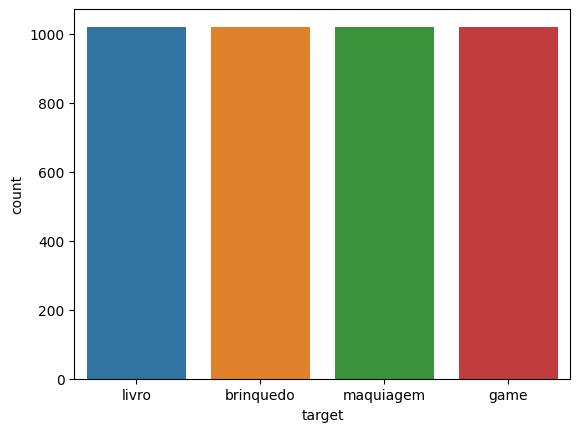

In [11]:
import seaborn as sns
sns.countplot(x=df['target'],label="Count") 
plt.show() # plota o gráfico por categoria

### Wordcloud (corrigir)

from wordcloud import WordCloud

def create_wordcloud(df, text_column, color="blue"):
    print(text_column)
    text = " ".join(df[text_column].astype(str))
    word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color=color,
        collocations=False
    ).generate(text)

    return word_cloud.to_array()  # Convert WordCloud object to a NumPy array (image)

word_cloud_image = create_wordcloud(df_cleaned,"cleaned_text")

Plot the word cloud image on the appropriate subplot

plt.imshow(word_cloud_image, interpolation='bilinear')
plt.title('Word Cloud do sentimento neutro sem os nomes dos candidatos')
plt.show()

## Fazendo separação das palavras e removendo pontuação

In [18]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
df_cleaned['tokens'] = df_cleaned['cleaned_text'].apply(tokenizer.tokenize) # aplica o regex tokenizer
print(df_cleaned['tokens'].head())

from nltk.probability import FreqDist
fdist = df_cleaned['tokens'].apply(FreqDist) # calcula a frequência de cada token
print(fdist.head()) # frequencia na coluna sem stop_words


0    [produto, novobilbo, bolseiro, hobbit, leva, v...
1    [produto, novodurante, férias, escolares, 1958...
2    [produto, novotodo, reino, westeros, alcance, ...
3    [produto, novo, físico, série, harry, potter, ...
4    [produto, novode, onde, viemos, onde, vamos, r...
Name: tokens, dtype: object
0    {'produto': 1, 'novobilbo': 1, 'bolseiro': 1, ...
1    {'produto': 1, 'novodurante': 1, 'férias': 1, ...
2    {'produto': 1, 'novotodo': 1, 'reino': 1, 'wes...
3    {'produto': 2, 'novo': 1, 'físico': 1, 'série'...
4    {'produto': 1, 'novode': 1, 'onde': 2, 'viemos...
Name: tokens, dtype: object


### A impressão acima mostra a frequência das palavras após tratamentos para lowercase e sem stopwords. Abaixo segue as listas sem tratamentos.

In [21]:
fdist_comstop = products_data['informacao'].apply(tokenizer.tokenize).apply(FreqDist)
print(fdist_comstop.head()) # Frequencia na coluna com stop_words

0    {'Produto': 1, 'NovoBilbo': 1, 'Bolseiro': 1, ...
1    {'Produto': 1, 'NovoDurante': 1, 'as': 1, 'fér...
2    {'Produto': 1, 'NovoTodo': 1, 'o': 1, 'reino':...
3    {'Produto': 2, 'Novo': 1, 'e': 33, 'Físico': 1...
4    {'Produto': 1, 'NovoDe': 1, 'Onde': 2, 'Viemos...
Name: informacao, dtype: object


In [22]:
df_cleaned.head()

,informacao,target,cleaned_text,tokens
0,produto novobilbo bolseiro é um hobbit que lev...,livro,produto novobilbo bolseiro hobbit leva vida co...,"[produto, novobilbo, bolseiro, hobbit, leva, v..."
1,produto novodurante as férias escolares de 195...,livro,"produto novodurante férias escolares 1958 , de...","[produto, novodurante, férias, escolares, 1958..."
2,produto novotodo o reino de westeros ao alcanc...,livro,produto novotodo reino westeros alcance mãos s...,"[produto, novotodo, reino, westeros, alcance, ..."
3,produto novo e físico a série harry potter ch...,livro,produto novo físico série harry potter chega p...,"[produto, novo, físico, série, harry, potter, ..."
4,produto novode onde viemos? para onde vamos? r...,livro,produto novode onde viemos ? onde vamos ? robe...,"[produto, novode, onde, viemos, onde, vamos, r..."


## Stemmer.
Extrai o sufixo das palavras, usado para facilitar a associação entre palavras com sentidos próximos.


Precisão razoável.


Por exemplo:


In [24]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("portuguese")

In [25]:
print(stemmer.stem("livro"))
print(stemmer.stem("livreiro"))
print(stemmer.stem("livraria"))

livr
livreir
livr


In [35]:
df_cleaned['stemmed'] = df_cleaned['tokens'].apply(lambda x: [stemmer.stem(y) for y in x]) # Aplica o stemmer pra cada palavra
df_processed = df_cleaned.drop(columns=["tokens","informacao"]) # Exclui a coluna sem o stemmer

In [36]:
df_processed.head() # Mostra o dataframe

,target,cleaned_text,stemmed
0,livro,produto novobilbo bolseiro hobbit leva vida co...,"[produt, novobilb, bolseir, hobbit, lev, vid, ..."
1,livro,"produto novodurante férias escolares 1958 , de...","[produt, novodur, fér, escol, 1958, derry, pac..."
2,livro,produto novotodo reino westeros alcance mãos s...,"[produt, novotod, rein, wester, alcanc, mã, sé..."
3,livro,produto novo físico série harry potter chega p...,"[produt, nov, físic, séri, harry, pott, cheg, ..."
4,livro,produto novode onde viemos ? onde vamos ? robe...,"[produt, novod, onde, viem, onde, vam, robert,..."


### passo opcional para converter tokens em inteiros: 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X['stemmed'] = X['stemmed'].apply(lambda col: le.fit_transform(col)) # transforma as palavras em inteiros
print(X['stemmed'].head(10))

y = le.fit_transform(y) # transforma cada categoria em um inteiro


fdist = X['stemmed'].apply(FreqDist) # calcula a frequência de cada token
print(fdist.head(10))

## Une os tokens em uma única string novamente para ser usada com FeatureExtraction

#df_processed["strings"]= df_processed["stemmed"].str.join(" ") # reunindo cada elemento da lista

In [39]:
df_processed["strings"]= df_processed["stemmed"].str.join(" ") # reunindo cada elemento da lista
df_processed.head()

,target,cleaned_text,stemmed,strings
0,livro,produto novobilbo bolseiro hobbit leva vida co...,"[produt, novobilb, bolseir, hobbit, lev, vid, ...",produt novobilb bolseir hobbit lev vid confort...
1,livro,"produto novodurante férias escolares 1958 , de...","[produt, novodur, fér, escol, 1958, derry, pac...",produt novodur fér escol 1958 derry pacat cida...
2,livro,produto novotodo reino westeros alcance mãos s...,"[produt, novotod, rein, wester, alcanc, mã, sé...",produt novotod rein wester alcanc mã séri crôn...
3,livro,produto novo físico série harry potter chega p...,"[produt, nov, físic, séri, harry, pott, cheg, ...",produt nov físic séri harry pott cheg pratelei...
4,livro,produto novode onde viemos ? onde vamos ? robe...,"[produt, novod, onde, viem, onde, vam, robert,...",produt novod onde viem onde vam robert langdon...


## Separando os dados em treino e teste
80% para treino e 20% para teste


### CountVectorizer

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

X_train,X_test,y_train,y_test = train_test_split( # Separação dos dados para teste e treino
    df_processed["strings"], 
    df_processed["target"], 
    test_size = 0.33, 
    random_state = 10
)
# Converte as strings para uma matriz de contagem dos tokens
vect = CountVectorizer()
vect.fit(df_processed["strings"])

dataset = { 
    "X_train": vect.transform(X_train),
    "X_test": vect.transform(X_test),
    "y_train": y_train,
    "y_test" : y_test,
    "vect": vect
}

### TfidfVectorizer

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# um classificador linear que utiliza o Gradiente Descendente Estocástico como método de treino. 
# Por padrão, utiliza o estimador SVM.
from sklearn.linear_model import SGDClassifier
# Uma rede neural Perceptron Multicamadas
from sklearn.neural_network import MLPClassifier

vectorizer = TfidfVectorizer()
X_train_tfidf_vectorize = vectorizer.fit_transform(X_train)

## Treino

In [43]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(dataset["X_train"], dataset["y_train"])

products_model = {
    "clf" : clf,
    "vect": dataset["vect"]
}

In [44]:
#clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(70, ), random_state=1, verbose=True)
clf.fit(X_train_tfidf_vectorize, y_train) # Treino do classificador

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      1389154     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39548D+00    |proj g|=  4.96654D-02


 This problem is unconstrained.



At iterate    1    f=  1.36761D+00    |proj g|=  7.26860D-02

At iterate    2    f=  1.31911D+00    |proj g|=  4.64021D-02

At iterate    3    f=  1.22013D+00    |proj g|=  7.07583D-02

At iterate    4    f=  1.06267D+00    |proj g|=  2.10391D-01

At iterate    5    f=  7.40746D-01    |proj g|=  1.82635D-01

At iterate    6    f=  5.75905D-01    |proj g|=  5.93391D-02

At iterate    7    f=  4.41545D-01    |proj g|=  2.48162D-01

At iterate    8    f=  3.82609D-01    |proj g|=  3.43705D-01

At iterate    9    f=  3.09556D-01    |proj g|=  7.49817D-02

At iterate   10    f=  2.85312D-01    |proj g|=  8.38132D-02

At iterate   11    f=  2.70587D-01    |proj g|=  3.39439D-02

At iterate   12    f=  2.62130D-01    |proj g|=  2.39996D-02

At iterate   13    f=  2.45541D-01    |proj g|=  9.67343D-02

At iterate   14    f=  2.22563D-01    |proj g|=  5.98253D-02

At iterate   15    f=  1.68262D-01    |proj g|=  2.20244D-02

At iterate   16    f=  1.30864D-01    |proj g|=  4.22603D-02

At iter

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(70,), random_state=1,
              solver='lbfgs', verbose=True)

# Testes

In [45]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
# Multinomial NB
y_prediction = products_model["clf"].predict(dataset["X_test"])
accuracy = accuracy_score(y_prediction, dataset["y_test"])

print ("Precisão do multinomialNB: ")
print (accuracy)

products_metrics = accuracy


# MPL Classifier
vect_transform = vectorizer.transform(X_test)
predicted = clf.predict(vect_transform)

print ("Precisão do multinomialNB: ")
print(metrics.classification_report(y_test, predicted,target_names=y_test.unique()))


Precisão do multinomialNB: 
0.9710467706013363
Precisão do multinomialNB: 
              precision    recall  f1-score   support

   maquiagem       0.98      0.99      0.98       348
       livro       0.99      0.97      0.98       355
        game       0.98      0.98      0.98       341
   brinquedo       0.98      1.00      0.99       303

    accuracy                           0.98      1347
   macro avg       0.98      0.98      0.98      1347
weighted avg       0.98      0.98      0.98      1347



In [46]:
input_message = ["sombra"]
input_message = products_model["vect"].transform(input_message)
final_prediction = products_model["clf"].predict(input_message)[0]


In [47]:
print("Predicted value: " + final_prediction)

Predicted value: maquiagem
